## Clustering Narcotics Violations in Chicago
### Janneke Morin

+ Data Source: Chicago Open Data Portal
    + https://data.cityofchicago.org/Public-Safety/Crimes-2018/3i3m-jwuy
+ Objective: determine hotspots for narcotics violations in Chicago
+ Scenario: A task has been setup in the city of Chicago to crack down on 'NARCOTICS'.
    + Part of the strategy of the task is use of 'predictive policing' to deploy officers in known narcotics hotspots + increase surveillance and police presence in the neighborhoods.

### Process Summary
+ load data
+ filter to only narcotics violations
+ scale 'Latitude', 'Longitude',
+ cluster 'Latitude', 'Longitude',
+ plot clusters
+ silhouette plot clusters
+ barplot cluster centers by count

In [10]:
# load data
import pandas as pd
file_name = 'Crimes_-_2018.csv'
data = pd.read_csv(file_name)
data.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11583786,JC132741,12/25/2018 08:00:00 PM,010XX E 90TH ST,0930,MOTOR VEHICLE THEFT,THEFT/RECOVERY: AUTOMOBILE,STREET,False,False,...,8.0,47.0,07,NaN,NaN,2018,02/03/2019 04:01:10 PM,NaN,NaN,NaN


In [ ]:
set(data['Primary Type'])

In [ ]:
# filter to only narcotics violations
# scale 'Latitude', 'Longitude'
from sklearn.preprocessing import StandardScaler 

data_filtered = data.loc[data['Primary Type'] == 'NARCOTICS', ['Latitude','Longitude']]
data_filtered.dropna(inplace=True)
s = StandardScaler()
data_scaled = s.fit_transform(data_filtered)
data_scaled.shape

In [ ]:
# loop through a series of cluster numbers
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
scores = []
# create a list of number of clusters to try
cluster_list = list(range(10, 201, 10))

# loop through each element of the list, building a cluster model with that elements number of centers
for i,j in enumerate(cluster_list):
    n_clusters = j
    model_temp =  KMeans(n_clusters=n_clusters)
    model_temp.fit(X=data_scaled)
    cluster_labels = model_temp.predict(data_scaled)
    scores.append(silhouette_score(data_scaled, cluster_labels))

In [ ]:
# create a line plot of silhouette scores to determine the optimal cluster number
plt.figure()
plt.plot(cluster_list, scores)
plt.ylabel('sillioutte score')
plt.xlabel('number of cluster centers')
plt.show()

In [15]:
# initialize the cluster model with KMeans
model =  KMeans(n_clusters=150) 
model.fit(X=data_scaled)
clusters = model.predict(data_scaled)

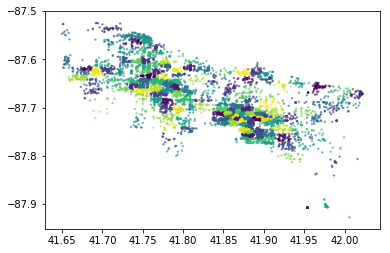

In [16]:
# cluster and plot 'Latitude', 'Longitude',
x = data_filtered['Latitude']
y = data_filtered['Longitude']
colors = clusters
plt.figure()
plt.scatter(x, y,s =2, c=clusters, alpha=.5)
plt.show()

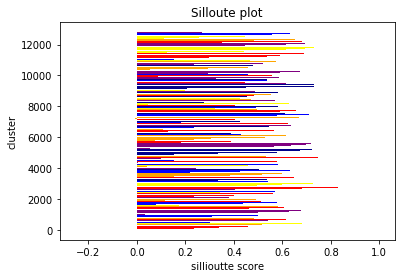

In [17]:
# silhouette plot clusters
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.colors import LinearSegmentedColormap

# between -1 and 1, higher number indicates you have good configurations
clusters = model.predict(data_scaled)

# get the s score for each row of data
scores = silhouette_samples(data_scaled, clusters)

# get the s score the the entire data set
silhouette_score(data_scaled, clusters)

cmap = ['red','orange', 'yellow', 'blue', 'darkblue', 'purple'] * 100
colors = [cmap[j] for  _, j in enumerate(clusters)]

# create a bar plot to show each silhouette
to_plot = pd.DataFrame({'scores':scores, 'labels':clusters, 'colors': colors})
to_plot.sort_values(['labels', 'scores'], inplace=True)

plt.figure()
plt.barh(range(to_plot.shape[0]), to_plot['scores'], color= to_plot['colors'])
plt.xlabel('Silhouette Score')
plt.ylabel('Cluster')
plt.title('Silhouette Plot')
plt.show()

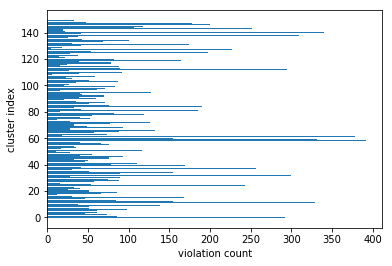

In [18]:
# barplot cluster centers by count
cluster_df = pd.DataFrame({'clusters':clusters})
cluster_df = cluster_df.groupby('clusters')['clusters'].count()
cluster_df.sort_values(inplace=True)

plt.figure()
plt.barh(cluster_df.index, cluster_df.values )
plt.xlabel('Violation Count')
plt.ylabel('Cluster Index')
plt.show()

In [19]:
# determine the three problem areas for police deployment by cluster
import numpy as np
cluster_df.sort_values(ascending=False).head(3)

clusters
58     392
61     379
140    340
Name: clusters, dtype: int64

In [20]:
# get the gps coords out for the center of each cluster
import numpy as np
centers = model.cluster_centers_
center_array = s.inverse_transform(centers)
print(center_array[58])
print(center_array[61])
print(center_array[140])

[ 41.79537615 -87.63219935]
[ 41.75649801 -87.63414688]
[ 41.92864047 -87.77955227]


## Summary
According to this method, the three biggest narcotics hotspots are:
+
+      [41.79537615 -87.63219935] 5434 S Wells St, Chicago, IL 60609
+      [41.75649801 -87.63414688] South Side, Chicago, IL 60620
+      [41.92864047 -87.77955227] 2601-2699 N Moody Ave, Chicago, IL 60639

These areas are all particularly close in proximity. Given my findings, I recommend implementing 'predictive policing' and deploying officers to increase survallence and police presences in these areas and neighborhoods.

To extract these hotspots, I first loaded the Chicago Crimes dataset and filtered it to include only narcotics violations. Then, I scaled and clustered the dataset by latitude and longitude to allow for the matching of patterns in violations to specific geographical areas.

After filtering and scaling the data, I determined the optimal cluster number by looping through each element of a list of amounts to try. In the graph of silhouette scores for each amount, an increase in cluster amount after 150 clusters does not increase the score, so I chose to work with this number. I next graphed these clusters and their silhouette scores.

These plots satisfied, so I moved on to extract the three hotspots with the highest violation count from a horizantal barplot (cluster 58, 61, and 140). The GPS coordiantes (longitude and latitude) for the center of each cluster translated to the hotspot location.

A potential pitfall of this method is an unavoidable uncertainty in the cluster boundaries evidenced by the imperfect silhouette scores. Another consideration I noticed is that there is a random component to KMeans; the clusters were slightly varied each time I ran them, even with the same amount. However, an advantage to clustering is the ability minimize this uncertainty by looping through potential cluster amounts to determine the optimal one given silhouette scores. It also allows us to easily identify areas with the highest counts of narcotics violations and translate them into GPS points where action can be taken.